# Prognosis and survival functions

In this project, we will analyze observations from different patients who suffered a heart attack and we will create different survival functions employing univariate (Kaplan-Meier estimate) and multivariate (Cox proportional hazards and survival forests) analysis.

In [20]:
# Libraries to be used. Feel free to add more libraries if you need them
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install lifelines
from lifelines import CoxPHFitter
from sklearn.model_selection import train_test_split
!pip install scikit-survival
from sksurv.ensemble import RandomSurvivalForest
from sksurv.preprocessing import OneHotEncoder


**DATA**

The data that we are going to use in this lab is described in the paper ["Survival analysis of heart failure patients: A case study"](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0181001). According to the authors: 

*Current study is based on 299 patients of heart failure comprising of 105 women and 194 men. All the patients were more than 40 years old, having left ventricular systolic dysfunction and falling in NYHA class III and IV. Follow up time was 4–285 days with an average of 130 days. Disease was diagnosed by cardiac echo report or notes written by physician. Age, serum sodium, serum creatinine, gender, smoking, Blood Pressure (BP), Ejection Fraction (EF), anemia, platelets, Creatinine Phosphokinase (CPK) and diabetes were considered as potential variables explaining mortality caused by CHD [...]. The information related to risk factors were taken from blood reports while smoking status and blood pressure were taken from physician’s notes.*






In [21]:
#Load  the data
sData='https://plos.figshare.com/ndownloader/files/8937223'
urllib.request.urlretrieve(sData,'./HeartFailure.csv')
df=pd.read_csv('./HeartFailure.csv')

In [22]:
# Visualize the data and obtain statistics (number of observations and predictor variables)
print('Number of observations: ', len(df))
print('Number of predictor variables: ', len(df.columns)-2)
df.head()


Number of observations:  299
Number of predictor variables:  11


,TIME,Event,Gender,Smoking,Diabetes,BP,Anaemia,Age,Ejection.Fraction,Sodium,Creatinine,Pletelets,CPK
0,97,0,0,0,0,0,1,43.0,50,135,1.30,237000.00,358
1,180,0,1,1,1,0,1,73.0,30,142,1.18,160000.00,231
2,31,1,1,1,0,1,0,70.0,20,134,1.83,263358.03,582
3,87,0,1,0,0,0,1,65.0,25,141,1.10,298000.00,305
4,113,0,1,0,0,0,0,64.0,60,137,1.00,242000.00,1610


# 1. Univariate analysis: Univariate survival functions and cumulative hazard

**TASK 1:** Calculating and plot the survival function employing the Kaplan-Meier estimate 

In [23]:
# Calculate and plot the survival function employing the Kaplan-Meier estimate
def calculate_survival_KM(df_inp, TimeColumn, EventColumn):
  prob_survival = [0]
  p = 1
  time = [p]
  TimeColumn = 'TIME'
  EventColumn = 'Event'
  unique_followup_time = df_inp[TimeColumn].unique()
  unique_followup_time = sorted(unique_followup_time) # Sorting the unique times 
  for t in unique_followup_time:
    n_survived = len(df_inp[(df_inp[TimeColumn]>=t)]) # People that survived for time greater than or equal to t 
    n_died = len(df_inp[(df_inp[TimeColumn]==t)&(df_inp[EventColumn]==1)]) # people that died at time t 
    p = p*(1-float(n_died/n_survived)) # Using kaplan meier formula 
    time.append(t) # Storing Time
    prob_survival.append(p) # Storing probablities

  dfSurv = pd.DataFrame(list(zip(time, prob_survival)), 
                columns =['Time', 'Probabiltity of Survival']) # Converting into data frame the time and survival probabilties 
  return dfSurv

# Plotting survival function 
def plot_survival(df_inp, TimeColumn, EventColumn, Name):
  dfSurv = calculate_survival_KM(df_inp, TimeColumn, EventColumn) 
  plt.plot(dfSurv.iloc[1:,0],dfSurv.iloc[1:,1],label=Name)
  plt.legend()
  plt.grid()
  plt.xlabel('Time')
  plt.ylabel('Probabilty of survival')
  plt.show()
  



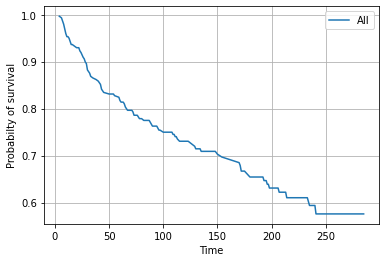

In [24]:
# Plot the survival function obtained with the whole dataframe
TimeColumn='TIME'
EventColumn='Event'
plot_survival(df, TimeColumn, EventColumn, 'All')

**TASK 2:** Coding a function that displays the survival function of two categories of a certain predictor (eg. smoker and non-smoker or male, female) in the same plot.

In [64]:
# function to print two categories 
def plot_survival_twocat(df_inp, predictor, cat1, cat0):
  df_cat1 = df_inp[df_inp[predictor] == 1] # Getting dataframe for category 1
  df_cat0 = df_inp[df_inp[predictor] == 0] # Getting dataframe for category 0
  dfSurv_cat1 = calculate_survival_KM(df_cat1, 'TIME', 'Event') # Getting survival function for category 1
  dfSurv_cat0 = calculate_survival_KM(df_cat0, 'TIME', 'Event') # Getting survival function for category 0
  plt.plot(dfSurv_cat1.iloc[1:,0],dfSurv_cat1.iloc[1:,1],label=cat1)
  plt.plot(dfSurv_cat0.iloc[1:,0],dfSurv_cat0.iloc[1:,1],label=cat0)
  plt.ylim([0,1])
  plt.legend()
  plt.xlabel('Time')
  plt.ylabel('Probability of survival')
  plt.grid()
  plt.show()


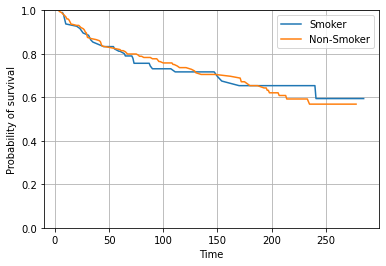

In [65]:
# Plot survival for smokers vs nonsmokers
predictor='Smoking'
cat1='Smoker'
cat0='Non-Smoker'
plot_survival_twocat(df, predictor, cat1, cat0)

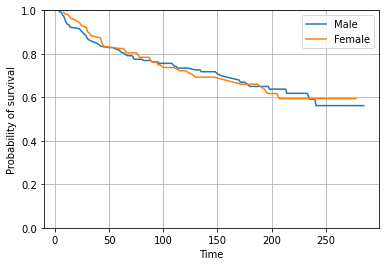

In [66]:
# Plot survival for male vs female (hint: compare your figure with the survival functions
# provided in the original paper; both should be almost identical)
predictor='Gender'
cat1='Male'
cat0='Female'
plot_survival_twocat(df, predictor, cat1, cat0)

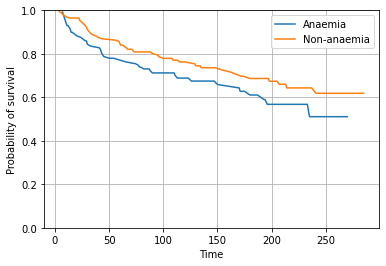

In [67]:
# Plot survival for anaemia vs non-anaemia
predictor='Anaemia'
cat1='Anaemia'
cat0='Non-anaemia'
plot_survival_twocat(df, predictor, cat1, cat0)

**TASK 3:** Ploting the cumulative Hazard using the Nelson-Aalen estimator 

In [68]:
# Plot the cumulative Hazard using the Nelson-Aalen estimator
def cumulative_hazard_NA(df_inp, TimeColumn, EventColumn):
  cumulative_hazard = [0]
  p = 0
  time = [p]
  unique_followup_time = df_inp[TimeColumn].unique()
  unique_followup_time = sorted(unique_followup_time)
  for t in unique_followup_time:
    n_survived = len(df_inp[(df_inp[TimeColumn]>=t)]) # People who survived for time greater than or equal to t 
    n_died = len(df_inp[(df_inp[TimeColumn]==t)&(df_inp[EventColumn]==1)]) # People who died at time t
    p = p+float(n_died/n_survived) # Using Nelson-Aalen estimator formula
    time.append(t)
    cumulative_hazard.append(p)

  dfH = pd.DataFrame(list(zip(time, cumulative_hazard)),
                columns =['Time', 'Cumulative Hazard']) # Forming dataframe for time and hazard
  return dfH

# Plotting the hazard 
def plot_cumH(df_inp, TimeColumn, EventColumn, Name):
  dfH = cumulative_hazard_NA(df_inp, TimeColumn, EventColumn)
  plt.plot(dfH.iloc[1:,0],dfH.iloc[1:,1],label=Name)
  plt.grid()
  plt.xlabel('Time')
  plt.ylabel('Cumulative Hazard')
  plt.legend()
  plt.show()


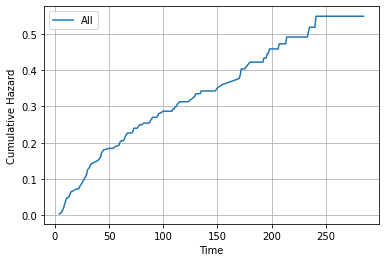

In [30]:
# Plot the cumulative hazard of df
TimeColumn='TIME'
EventColumn='Event'
plot_cumH(df, TimeColumn, EventColumn, 'All')

# 2. Multivariate analysis
**Cox Proportional Hazards**

Now, we are going to employ multivariate analysis using CPH to determine the survival funtions and the hazard ratio of different patients. 
We will employ [lifelines](https://lifelines.readthedocs.io/en/latest/index.html), a python survival analysis library.

**TASK 4:** Dividing the dataframe into training and testing subsets.

In [31]:
df_label=df[['Event','TIME']]
df_predictors = df.drop(columns=['Event','TIME'])
X_train, X_test, y_train, y_test = train_test_split(df_predictors, df_label, test_size=0.20,random_state=42) # Testing data = 20% and training data 80 %
dfTrain = pd.concat([y_train, X_train], axis=1) # Train dataset
dfTest = pd.concat([y_test,X_test],axis=1) # Test dataset


**TASK 5:** Calculating and printing the Cox proportional hazards coefficients of the training subset (dfTrain).

In [32]:
# Calculate and print the Cox proportional hazards coefficients
cph = CoxPHFitter() # Using cox proportional hazard function in lifelines library
cph.fit(dfTrain, 'TIME', event_col='Event')
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 239 total observations, 164 right-censored observations>
             duration col = 'TIME'
                event col = 'Event'
      baseline estimation = breslow
   number of observations = 239
number of events observed = 75
   partial log-likelihood = -351.44
         time fit was run = 2022-02-20 01:22:43 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                 
Gender             -0.28       0.76       0.28            -0.83             0.27                 0.44                 1.31
Smoking             0.11       1.12       0.28            -0.44             0.67                 0.64                 1.96
Diabetes           -0.06       0.94       0.25            -0.56             0.43                 0.57                 1.54
BP                  0.66       1.93       0.25             0.17             1.15                 1.18                 3.16
Anaemia             0.31       1.37       0.25            -0.17             0.80                 0.84                 2.22
Age                 0.05       1.05       0.01             0.03             0.07                 1.03                 1.07
Ejection.Fraction  -0.04       0.96       0.01            -0.07            -0.02                 0.93                 0.98
Sodium             -0.03       0.97       0.03            -0.09             0.03                 0.92                 1.03
Creatinine          0.28       1.32       0.09             0.09             0.46                 1.09                 1.58
Pletelets          -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
CPK                 0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00

                      z      p   -log2(p)
covariate                                
Gender            -1.00   0.32       1.66
Smoking            0.40   0.69       0.54
Diabetes          -0.25   0.80       0.32
BP                 2.63   0.01       6.86
Anaemia            1.27   0.20       2.29
Age                4.47 <0.005      16.98
Ejection.Fraction -3.65 <0.005      11.87
Sodium            -0.91   0.36       1.47
Creatinine         2.91 <0.005       8.12
Pletelets         -0.25   0.81       0.31
CPK                1.67   0.10       3.39
---
Concordance = 0.73
Partial AIC = 724.88
log-likelihood ratio test = 61.06 on 11 df
-log2(p) of ll-ratio test = 27.34

**TASK 6:** Ploting the survival function of the three first participants in the test subset.

Text(0, 0.5, 'Probabilty of survival')

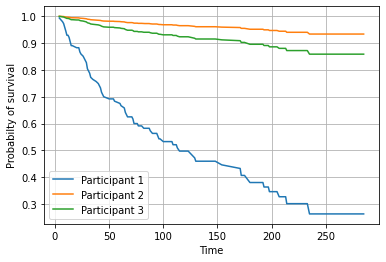

In [33]:
# Plot the survival function of the three first participants in the test subset
participant1=0 # Participant's index in the testing dataframe
participant2=1
participant3=2
rows_selected = dfTest.iloc[[0,1,2], 2:]
cph.predict_survival_function(rows_selected).plot()
plt.legend(labels=['Participant 1','Participant 2','Participant 3'])
plt.grid()
plt.xlabel('Time')
plt.ylabel('Probabilty of survival')
  # YOUR CODE GOES HERE


As we can observe, the survival functions are proportional

**TASK 7:** Creating a function that calculates the hazard ratio between two patients. This will tell us which of the two patients is at a higher risk.

In [34]:
# Create a function that calculates the hazard ratio between two patients. This will tell us which patient is at a higher risk.
def hazard_ratio(df_inp, participant1, participant2, cph_in):
    import math
    sum_1 = sum_2 = 0
    participant_1 = df_inp.iloc[participant1,2:]
    participant_2 = df_inp.iloc[participant2,2:]
    params = cph_in.params_.values
    for i in range(len(params)):
      sum_1 = sum_1 + (participant_1[i]*params[i]) #Multiplying coef with corresponding predictot
      sum_2 = sum_2 + (participant_2[i]*params[i])
    theta_1 = math.exp(sum_1)
    theta_2 = math.exp(sum_2)
    HR = theta_1/theta_2
    return HR





In [35]:
print('Participant 1 vs participant 2 Hazard Ratio: ' + str(hazard_ratio(df, 2, 33,cph)))

Participant 1 vs participant 2 Hazard Ratio: 5.078482339629227


**TASK 8:** Creating a function to calculate the concordance index of the CPH model already trained, employing the testing data.

In [36]:
# concordance index function
def c_index_mlma(df_inp, TimeColumn, EventColumn, cph_in):
    co_pair = 0
    disco_pair = 0
    for i in range(len(df_inp)):
      for j in range(i+1,len(df_inp)):
          if (df_inp['Event'].iloc[i]==1) & (df_inp['Event'].iloc[j]==1): # Checking if event is one for both pairs 
            h =hazard_ratio(df_inp, i, j,cph_in)
            if (h>1) & ((df_inp['TIME'].iloc[i])<(df_inp['TIME'].iloc[j])): # Checking if risk is higher for patient with t less 
                      co_pair +=1
            elif (h<1) & ((df_inp['TIME'].iloc[i])>(df_inp['TIME'].iloc[j])):
                      co_pair+=1
            elif (h == 1) & ((df_inp['TIME'].iloc[i])==(df_inp['TIME'].iloc[j])):
                      co_pair+=1
            else:
                      disco_pair+=1                                           # If not then discordant pair
          elif (df_inp['Event'].iloc[i]==0) & (df_inp['Event'].iloc[j]==1):   # Condition when one data is censored, (0, 1) pair 
            h =hazard_ratio(df_inp, i, j,cph_in)
            if (h<1) & ((df_inp['TIME'].iloc[i])>(df_inp['TIME'].iloc[j])):
                      co_pair +=1
            elif (h>1)&((df_inp['TIME'].iloc[i])>(df_inp['TIME'].iloc[j])):
                      disco_pair+=1
          elif (df_inp['Event'].iloc[i]==1) & (df_inp['Event'].iloc[j]==0):   # Condition when one data is censored, (1, 0) pair 
            h =hazard_ratio(df_inp, i, j,cph_in)
            if (h>1) & ((df_inp['TIME'].iloc[i])<(df_inp['TIME'].iloc[j])):
                      co_pair +=1
            elif (h<1)&((df_inp['TIME'].iloc[i])<(df_inp['TIME'].iloc[j])):
                      disco_pair+=1

    CI = co_pair/(co_pair+disco_pair)



    return CI   

In [37]:
# Concordance Index of the training data
TimeColumn='TIME'
EventColumn='Event'
CI=c_index_mlma(dfTrain, TimeColumn, EventColumn, cph)
print(CI)

0.7320351279114166


In [38]:
# The result sholud be similar to the CI calculated by the lifelines library (+/- 0.015)
print(cph.concordance_index_)

0.7331093976639438


In [39]:
# Concordance Index of the testing data
TimeColumn='TIME'
EventColumn='Event'
CI=c_index_mlma(dfTest, TimeColumn, EventColumn, cph)
print(CI)

0.7694038245219348


**Survival forests**

Now, we are going to use a different type of multivariate analysis to calculate survival functions: Random Survival Forests. To perform this type of analysis, we will employ the [scikit-survival library](https://scikit-survival.readthedocs.io/en/stable/index.html). 


**TASK 9:** Training a random survival forest using the training subset.

In [40]:
# Creating random survival forest model
y_train['Event']=y_train['Event'].astype(bool)
y_train_struct = y_train.to_records(index=False) #Converting train labels to structured array
estimator = RandomSurvivalForest().fit(X_train, y_train_struct)

**TASK 10:** Calculating the C-I of the model when applied to the testing subset. Use the scikit-survival scoring functions to obtain the index. Comparing this result with the C-I obtained with the CPH models.

In [41]:

y_test['Event']=y_test['Event'].astype(bool)
y_test_struct = y_test.to_records(index=False)
estimator.score(X_test,y_test_struct) # Concordance Index for testing subset 

0.7739032620922385

**TASK 11:** Ploting the survival function of the three first patients in the testing subset. Comparing these survival functions with those obtained with the CPH models.

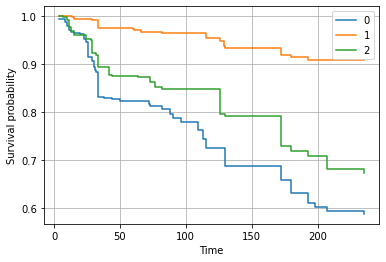

In [69]:
surv = estimator.predict_survival_function(X_test.iloc[[0,1,2],:], return_array=True)
for i, s in enumerate(surv):
    plt.step(estimator.event_times_, s, where="post", label=str(i))
plt.ylabel("Survival probability")
plt.xlabel("Time")
plt.legend()
plt.grid(True)

As we can observe, these functions are not proportional. Their shape depends on the predictor variables of each patient.